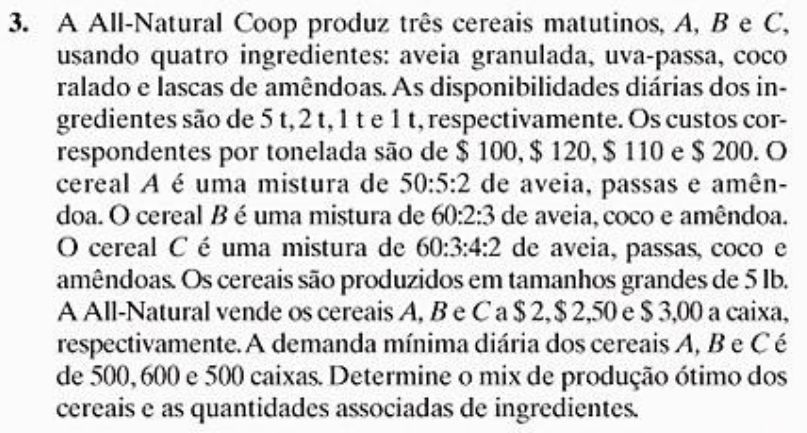

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Mix_Producao_Cereais_AllNatural')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Identificadores
cereais = ['A', 'B', 'C']
ingredientes = ['aveia', 'passas', 'coco', 'amendoas']

# Disponibilidade e custo dos ingredientes (por tonelada)
disponibilidade_ing_ton = {'aveia': 5, 'passas': 2, 'coco': 1, 'amendoas': 1}
custo_ing_ton = {'aveia': 100, 'passas': 120, 'coco': 110, 'amendoas': 200}

# Dados de venda e demanda
preco_cereal_caixa = {'A': 2.00, 'B': 2.50, 'C': 3.00}
demanda_min_caixas = {'A': 500, 'B': 600, 'C': 500}
libras_por_caixa = 5
libras_por_ton = 2000

# Conversão de unidades para TONELADAS
# Preço por tonelada = (Preço/caixa) * (Caixas/tonelada)
preco_cereal_ton = {
    c: preco_cereal_caixa[c] * (libras_por_ton / libras_por_caixa) for c in cereais
}
# Demanda em toneladas = (Demanda em caixas) * (Toneladas/caixa)
demanda_min_ton = {
    c: demanda_min_caixas[c] * (libras_por_caixa / libras_por_ton) for c in cereais
}

# Composição dos cereais (em partes)
composicao_ratios = {
    'A': {'aveia': 50, 'passas': 5, 'coco': 0, 'amendoas': 2},
    'B': {'aveia': 60, 'passas': 0, 'coco': 2, 'amendoas': 3},
    'C': {'aveia': 60, 'passas': 3, 'coco': 4, 'amendoas': 2}
}

# Conversão da composição para percentual
total_partes = {c: sum(composicao_ratios[c].values()) for c in cereais}
composicao_perc = {
    c: {i: composicao_ratios[c][i] / total_partes[c] for i in ingredientes}
    for c in cereais
}

# Pré-cálculo do lucro líquido por tonelada de cada cereal
custo_cereal_ton = {
    c: sum(composicao_perc[c][i] * custo_ing_ton[i] for i in ingredientes)
    for c in cereais
}
lucro_cereal_ton = {c: preco_cereal_ton[c] - custo_cereal_ton[c] for c in cereais}

In [4]:
# 1. Variáveis de Decisão
# Quantidade (em toneladas) de cada cereal a ser produzida
toneladas_cereal = model.continuous_var_dict(cereais, name='Ton')


# 2. Função Objetivo
# Maximizar o lucro total
expressao_lucro = (lucro_cereal_ton[c] * toneladas_cereal[c] for c in cereais)
lucro_total = model.sum(expressao_lucro)
model.maximize(lucro_total)


# 3. Restrições

# Restrição 1: Disponibilidade de Ingredientes
# O total de cada ingrediente usado na produção não pode exceder a disponibilidade.
for i in ingredientes:
    expressao_uso_ing = (composicao_perc[c][i] * toneladas_cereal[c] for c in cereais)
    soma_uso_ing = model.sum(expressao_uso_ing)
    restr_ing_logica = soma_uso_ing <= disponibilidade_ing_ton[i]
    model.add_constraint(restr_ing_logica, ctname=f'disponibilidade_{i}')

# Restrição 2: Demanda Mínima
# A produção de cada cereal deve atender à demanda mínima diária.
for c in cereais:
    restr_demanda_logica = toneladas_cereal[c] >= demanda_min_ton[c]
    model.add_constraint(restr_demanda_logica, ctname=f'demanda_min_{c}')

In [5]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    lucro_maximo = model.objective_value
    print(f"Lucro Diário Máximo: ${lucro_maximo:,.2f}\n")

    print("--- Plano de Produção de Cereais ---")
    for c in cereais:
        prod_ton = toneladas_cereal[c].solution_value
        prod_caixas = prod_ton * (libras_por_ton / libras_por_caixa)
        print(f"  - Cereal {c}: {prod_ton:,.2f} toneladas ({prod_caixas:,.0f} caixas)")

    print("\n--- Quantidades de Ingredientes a Utilizar (toneladas) ---")
    for i in ingredientes:
        uso_ing_total = sum(composicao_perc[c][i] * toneladas_cereal[c].solution_value for c in cereais)
        if uso_ing_total > 1e-6:
            print(f"  - {i.capitalize()}: {uso_ing_total:,.2f} toneladas")
else:
    print("Não foi possível encontrar uma solução.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Tried aggregator 1 time.
LP Presolve eliminated 7 rows and 3 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)

------ SOLUÇÃO ÓTIMA ------

Lucro Diário Máximo: $5,384.84

--- Plano de Produção de Cereais ---
  - Cereal A: 1.25 toneladas (500 caixas)
  - Cereal B: 1.50 toneladas (600 caixas)
  - Cereal C: 2.90 toneladas (1,159 caixas)

--- Quantidades de Ingredientes a Utilizar (toneladas) ---
  - Aveia: 5.00 toneladas
  - Passas: 0.24 toneladas
  - Coco: 0.21 toneladas
  - Amendoas: 0.20 toneladas
